<a href="https://www.kaggle.com/code/iqmansingh/co2-emission-regression-baseline-xgb-lgbm?scriptVersionId=138707347" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src = "https://raw.githubusercontent.com/IqmanS/Kaggle-Playground-Series/main/3.20_CO2_Emissions/co2-banner.jpg?token=GHSAT0AAAAAAB77JULXGQI7SU4EUIOWNMNWZGKRR3A">

# **PREDICTING CO2 EMISSIONS IN RWANDA**

---


# Importing Libraries

In [44]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')
print("Setup Complete")

Setup Complete


# Importing Dataset

In [45]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")

In [46]:
train_data.drop(["ID_LAT_LON_YEAR_WEEK"],inplace=True,axis=1)
# test_data.drop(["ID_LAT_LON_YEAR_WEEK"],inplace=True,axis=1)

In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 non-null  float64
 8   SulphurDioxide_s

# Dealing with 'NaN' Values

In [48]:
mean = train_data.mean()

In [50]:
for i in train_data.columns:
    if i!="emission":
        train_data[i].fillna(value = mean[i], inplace=True)
        test_data[i].fillna(value = mean[i], inplace=True)

# EDA


In [65]:
allCols = train_data.columns
reqCols = [0,1,2,3,4,13,21,33,41,47,56,63]

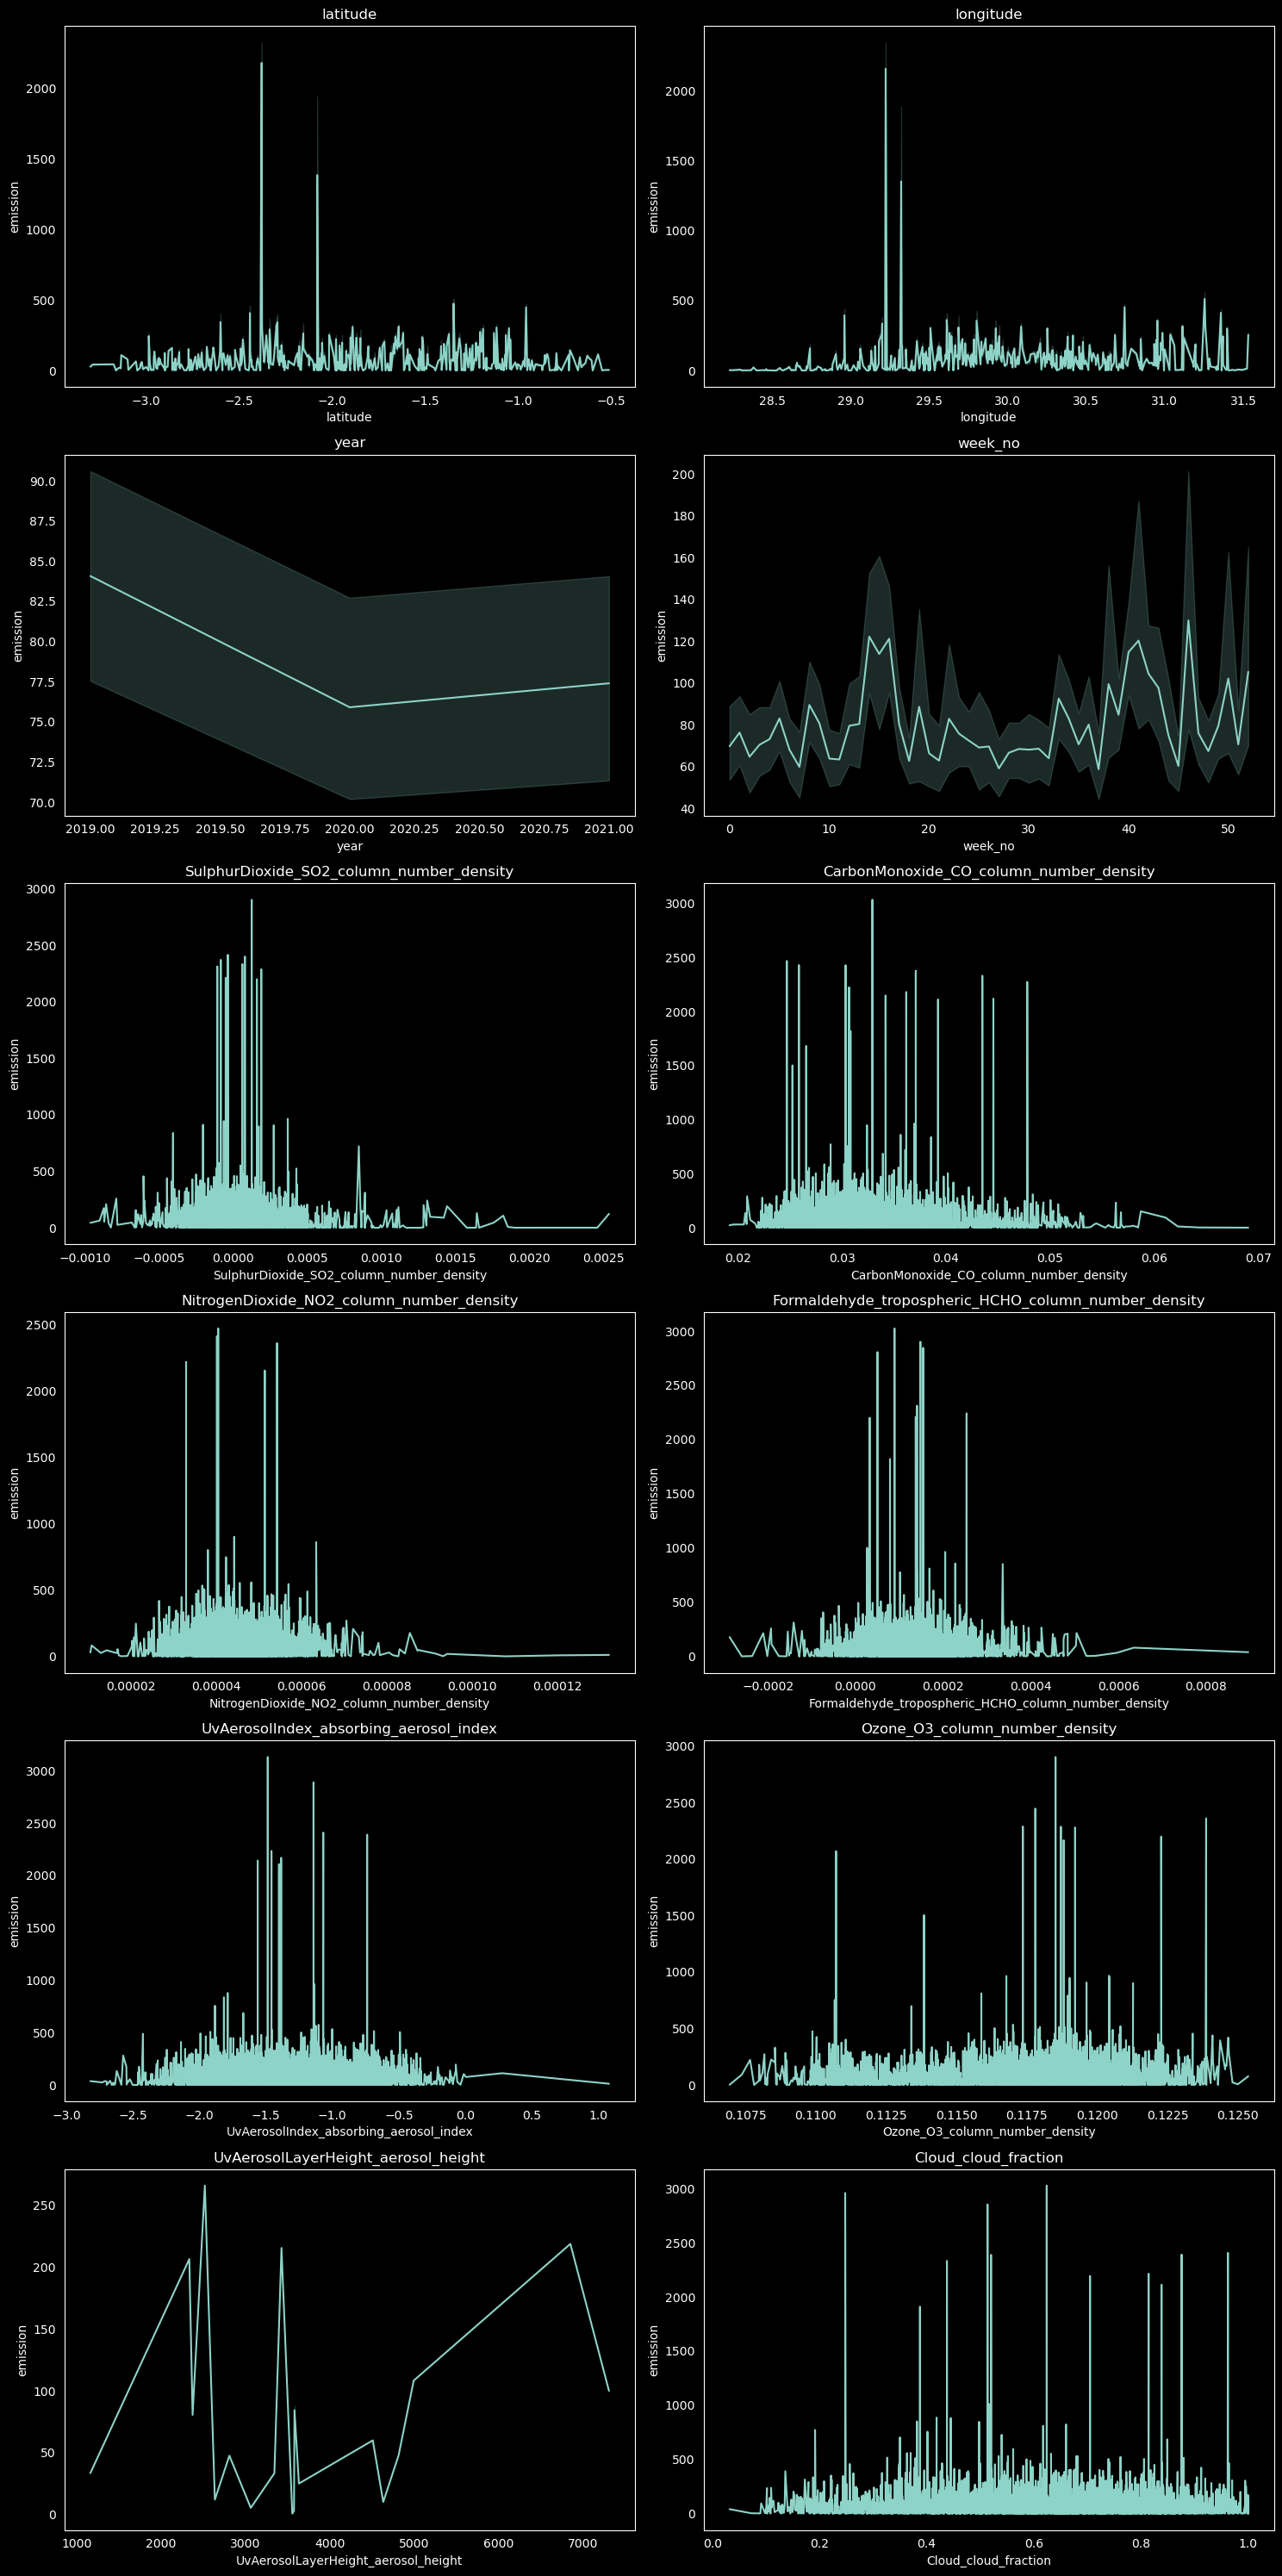

In [90]:
fig, axes = plt.subplots(6,2,figsize=(15, 30))
k = 1
for i in reqCols:
    plt.subplot(6,2,k)
    sns.lineplot(train_data.sample(5000),x=allCols[i],y=allCols[74],palette="flare");
    plt.gca().set_title(allCols[i])
    k+=1
    
fig.tight_layout()
plt.show()

# Model Creation

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, ensemble
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_error
from sklearn.linear_model import SGDRegressor, HuberRegressor
from sklearn.linear_model import BayesianRidge
cols = [i for i in train_data.columns if i!="emission"]
X = train_data[cols]
y = train_data.emission
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=100)
seed = np.random.seed(0)

In [80]:
rfmodel = RandomForestRegressor(random_state=seed)
rfmodel.fit(X_train,y_train)
print("RMSE of RF is ", mean_squared_error(y_test,rfmodel.predict(X_test),squared=False))

RMSE of RF is  25.985403050371453


In [82]:
xgbmodel = XGBRegressor(random_state=seed)
xgbmodel.fit(X_train,y_train)
print("RMSE of XGB is ", mean_squared_error(y_test,xgbmodel.predict(X_test),squared=False))

RMSE of XGB is  26.75752681530923


In [83]:
lgbmodel = LGBMRegressor(random_state=seed)
lgbmodel.fit(X_train,y_train)
print("RMSE of LGBM is ", mean_squared_error(y_test,lgbmodel.predict(X_test),squared=False))

RMSE of LGBM is  29.273698966242183


In [84]:
import random
# rf, xgb, lgb
wt = [random.uniform(0.5,1) for i in range(3)]

In [85]:
vrmodel = VotingRegressor([('xgb', xgbmodel),('lgb', lgbmodel),('rf',rfmodel)],weights=wt)
vrmodel.fit(X_train,y_train)
print("RMSE of VR is ", mean_squared_error(y_test,vrmodel.predict(X_test),squared=False))

RMSE of VR is  22.908258962901407


# Creating 'submission.csv' Files for all models

In [86]:
submission = pd.DataFrame()
submission["ID_LAT_LON_YEAR_WEEK"] = test_data.ID_LAT_LON_YEAR_WEEK

In [89]:
models = [('xgb', xgbmodel),('lgb', lgbmodel),('rf',rfmodel),("vr",vrmodel)]
for i in models:
    i[1].fit(X,y)
    preds = i[1].predict(test_data.drop(["ID_LAT_LON_YEAR_WEEK"],axis=1))
    submission["emission"] = preds
    submission.to_csv(f"submission_{i[0]}.csv",header = True,index=False)